# Fraud Detection Model
In this tutorial I will walk you through one of the most important applications in machine learning, I will demonstrate how can construct a high-performance model to detect a credit card fraud by using deep learning model.

In [3]:
import numpy as np
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Import Keras, Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score \
    , fbeta_score, classification_report, confusion_matrix, precision_recall_curve, roc_auc_score \
    , roc_curve

# Dataset
The datasets contain transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have **492** frauds out of **284,807** transactions. The dataset is highly unbalanced, the positive class (frauds) account for **0.172%** of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. **Features V1, V2, ... V28** are the principal components obtained with PCA, the only features which have not been transformed with PCA are **'Time' and 'Amount'**. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [5]:
# Import the dataset
df_full = pd.read_csv('creditcard.csv')

# Print out first 5 row of the dataset
df_full.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Count the number of samples for each class (In this case we have 2 classes)
df_full.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
# It is obvious that this data set is highly unbalance
# It Easier to sort the datset by "class" for stratified sampling
df_full.sort_values(by='Class', ascending=False, inplace=True)

In [9]:
# Dorp out the eniter "Time" coloumn
df_full.drop('Time', axis=1, inplace=True)

# Assign the first "3000" samples to new dataframe
df_sample = df_full.iloc[:3000, :]

In [13]:
# Count the number of samples for each class again (In this case we have 2 classes)
df_sample.Class.value_counts()

0    2508
1     492
Name: Class, dtype: int64

In [14]:
shuffle_df = shuffle(df_sample, random_state=42)

In [15]:
# Spilt the dataset into 2 dataframe "train" & "test"
df_train = shuffle_df[0:2400]
df_test = shuffle_df[2400:]

In [16]:
# Spilt each dataframe into "feature" & "lable"
train_feature = np.array(df_train.values[:, 0:29])
train_label = np.array(df_train.values[:, -1])
test_feature = np.array(df_test.values[:, 0:29])
test_label = np.array(df_test.values[:, -1])

In [17]:
# Print out the size of train dataframe "should be of size 2400x29"
train_feature.shape

(2400, 29)

In [18]:
# Print out the size of test dataframe "should be of size 2400x1"
train_label.shape

(2400,)

In [19]:
# Standardize the features coloumns to increase the training speed
scaler = MinMaxScaler()
scaler.fit(train_feature)
train_feature_trans = scaler.transform(train_feature)
test_feature_trans = scaler.transform(test_feature)

In [20]:
# A function to plot the learning curves
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

# Model overview
In this tutorial I will use a **3 fully-connected layers** + **Dropout**, and **ReLu** as activation function, the first layer contains 200 units, the second also with 200 units, and the third with a single output unit. 
For optimization algorithm, I used **Adam optimization** to optimize the **Accuracy Matrix**.

In [21]:
#####################################################################################################    
# Constructing the CNN & training phase

# Select the type of the model
model = Sequential()

# Add the first Dense layer with 200 neuron units and ReLu activation function
model.add(Dense(units=200,
                input_dim=29,
                kernel_initializer='uniform',
                activation='relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))

# Add the second Dense layer with 200 neuron units and ReLu activation function
model.add(Dense(units=200,
                kernel_initializer='uniform',
                activation='relu'))

# Add Dropout to prevent overfitting
model.add(Dropout(0.5))

# Add the second Dense layer with 1 neuron units and Sigmoid activation function
model.add(Dense(units=1,
                kernel_initializer='uniform',
                activation='sigmoid'))

# Print out the model summary
print(model.summary())

# Configure the learning process by selecting 'Binary cross tropy' as a loss function
# 'Adam' as a optimization function, and to optimize the 'Accuracy matrix'  
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# Fit the model by pass 'train_feature_trans' as input for X, 'train_lable' as input for y
# number of epochs = 200 and batch size = 500
train_history = model.fit(x=train_feature_trans, y=train_label,
                          validation_split=0.8, epochs=200,
                          batch_size=500, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               6000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 46,401
Trainable params: 46,401
Non-trainable params: 0
_________________________________________________________________
None
Train on 479 samples, validate on 1921 samples
Epoch 1/200
 - 5s - loss: 0.6887 - acc: 0.7203 - val_loss: 0.6802 - val_acc: 0.8360
Ep

Epoch 86/200
 - 0s - loss: 0.1460 - acc: 0.9603 - val_loss: 0.1416 - val_acc: 0.9604
Epoch 87/200
 - 0s - loss: 0.1572 - acc: 0.9603 - val_loss: 0.1400 - val_acc: 0.9604
Epoch 88/200
 - 0s - loss: 0.1356 - acc: 0.9645 - val_loss: 0.1387 - val_acc: 0.9604
Epoch 89/200
 - 0s - loss: 0.1403 - acc: 0.9582 - val_loss: 0.1376 - val_acc: 0.9604
Epoch 90/200
 - 0s - loss: 0.1415 - acc: 0.9603 - val_loss: 0.1363 - val_acc: 0.9620
Epoch 91/200
 - 0s - loss: 0.1417 - acc: 0.9582 - val_loss: 0.1346 - val_acc: 0.9625
Epoch 92/200
 - 0s - loss: 0.1337 - acc: 0.9645 - val_loss: 0.1332 - val_acc: 0.9625
Epoch 93/200
 - 0s - loss: 0.1263 - acc: 0.9666 - val_loss: 0.1320 - val_acc: 0.9625
Epoch 94/200
 - 0s - loss: 0.1191 - acc: 0.9666 - val_loss: 0.1316 - val_acc: 0.9625
Epoch 95/200
 - 0s - loss: 0.1257 - acc: 0.9666 - val_loss: 0.1306 - val_acc: 0.9625
Epoch 96/200
 - 0s - loss: 0.1229 - acc: 0.9645 - val_loss: 0.1285 - val_acc: 0.9625
Epoch 97/200
 - 0s - loss: 0.1237 - acc: 0.9666 - val_loss: 0.126

Epoch 182/200
 - 0s - loss: 0.0756 - acc: 0.9833 - val_loss: 0.1149 - val_acc: 0.9714
Epoch 183/200
 - 0s - loss: 0.0642 - acc: 0.9854 - val_loss: 0.1160 - val_acc: 0.9714
Epoch 184/200
 - 0s - loss: 0.0730 - acc: 0.9833 - val_loss: 0.1159 - val_acc: 0.9714
Epoch 185/200
 - 0s - loss: 0.0669 - acc: 0.9833 - val_loss: 0.1150 - val_acc: 0.9719
Epoch 186/200
 - 0s - loss: 0.0694 - acc: 0.9833 - val_loss: 0.1142 - val_acc: 0.9724
Epoch 187/200
 - 0s - loss: 0.0596 - acc: 0.9812 - val_loss: 0.1140 - val_acc: 0.9714
Epoch 188/200
 - 0s - loss: 0.0630 - acc: 0.9854 - val_loss: 0.1143 - val_acc: 0.9719
Epoch 189/200
 - 0s - loss: 0.0724 - acc: 0.9833 - val_loss: 0.1149 - val_acc: 0.9719
Epoch 190/200
 - 0s - loss: 0.0659 - acc: 0.9854 - val_loss: 0.1150 - val_acc: 0.9719
Epoch 191/200
 - 0s - loss: 0.0659 - acc: 0.9833 - val_loss: 0.1152 - val_acc: 0.9719
Epoch 192/200
 - 0s - loss: 0.0658 - acc: 0.9854 - val_loss: 0.1150 - val_acc: 0.9719
Epoch 193/200
 - 0s - loss: 0.0583 - acc: 0.9854 - val

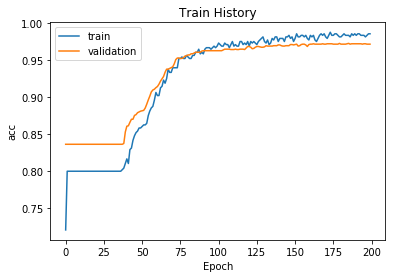

In [22]:
# Print out the accuracy curves for training and validation sets
show_train_history(train_history, 'acc', 'val_acc')

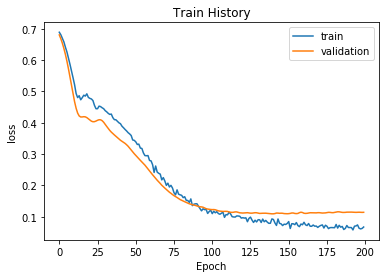

In [23]:
# Print out the loss curves for training and validation sets
show_train_history(train_history, 'loss', 'val_loss')

In [25]:
#####################################################################################################
# Evaluation phase

# Use the testing set to evaluate the model
scores = model.evaluate(test_feature_trans, test_label)

# Print out the accuracy
print('\n')
print('Accuracy=', scores[1])

600/600 [==============================] - 0s 60us/step


Accuracy= 0.98


Total number of test cases:  600


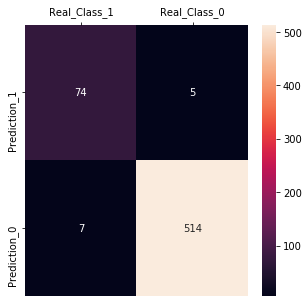

In [36]:
prediction = model.predict_classes(test_feature_trans)

df_ans = pd.DataFrame({'Real Class': test_label})
df_ans['Prediction'] = prediction

df_ans['Prediction'].value_counts()

df_ans['Real Class'].value_counts()

cols = ['Real_Class_1', 'Real_Class_0']  # Gold standard
rows = ['Prediction_1', 'Prediction_0']  # Diagnostic tool (our prediction)

B1P1 = len(df_ans[(df_ans['Prediction'] == df_ans['Real Class']) & (df_ans['Real Class'] == 1)])
B1P0 = len(df_ans[(df_ans['Prediction'] != df_ans['Real Class']) & (df_ans['Real Class'] == 1)])
B0P1 = len(df_ans[(df_ans['Prediction'] != df_ans['Real Class']) & (df_ans['Real Class'] == 0)])
B0P0 = len(df_ans[(df_ans['Prediction'] == df_ans['Real Class']) & (df_ans['Real Class'] == 0)])

conf = np.array([[B1P1, B0P1], [B1P0, B0P0]])
df_cm = pd.DataFrame(conf, columns=[i for i in cols], index=[i for i in rows])
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, ax=ax, fmt='d')

# Making x label be on top is common in textbooks.
ax.xaxis.set_ticks_position('top')

print('Total number of test cases: ', np.sum(conf))

In [38]:
# Model summary function
def model_efficacy(conf):
    total_num = np.sum(conf)
    sen = conf[0][0] / (conf[0][0] + conf[1][0])
    spe = conf[1][1] / (conf[1][0] + conf[1][1])
    false_positive_rate = conf[0][1] / (conf[0][1] + conf[1][1])
    false_negative_rate = conf[1][0] / (conf[0][0] + conf[1][0])

    print('Total number of test cases: ', total_num)
    print('G = gold standard, P = prediction')
    
    # G = gold standard; P = prediction
    print('G1P1: ', conf[0][0])
    print('G0P1: ', conf[0][1])
    print('G1P0: ', conf[1][0])
    print('G0P0: ', conf[1][1])
    print('--------------------------------------------------')
    print('Sensitivity: ', sen)
    print('Specificity: ', spe)
    print('False_positive_rate: ', false_positive_rate)
    print('False_negative_rate: ', false_negative_rate)


model_efficacy(conf)


Total number of test cases:  600
G = gold standard, P = prediction
G1P1:  74
G0P1:  5
G1P0:  7
G0P0:  514
--------------------------------------------------
Sensitivity:  0.9135802469135802
Specificity:  0.9865642994241842
False_positive_rate:  0.009633911368015413
False_negative_rate:  0.08641975308641975
